In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import requests
from tqdm.auto import tqdm
from urllib.parse import urlencode
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# считываем данные
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/1TFOJ7Z80VAEFw' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
df = pd.read_csv(requests.get(final_url).json()['href'], sep=';')
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [3]:
# убираем колонку 'Unnamed: 0'
df = df.drop('Unnamed: 0', axis=1)
df.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


In [4]:
# преобразуем value к типу float
df.value = df.value.str.replace(',', '.').apply(float)

In [5]:
# смотрим количество групп, количество наблюдений в каждой (оно одинаково)
df.experimentVariant.value_counts()

Treatment    500
Control      500
Name: experimentVariant, dtype: int64

In [6]:
# делим на две группы
control = df[df.experimentVariant == 'Control']
test = df[df.experimentVariant == 'Treatment']
control.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [7]:
test.head()

,value,experimentVariant
500,10.380495,Treatment
501,9.546867,Treatment
502,11.088215,Treatment
503,10.147274,Treatment
504,9.789808,Treatment


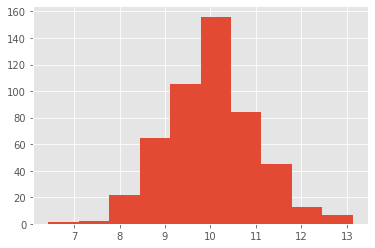

In [8]:
# построим графики распределения для каждой группы
control.value.hist()

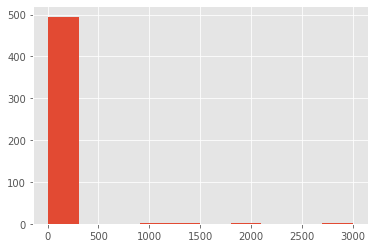

In [9]:
test.value.hist()

Визуально: в тестовой группе не соблюдён критерий нормальности распределения, присутствуют выбросы. T-критерий применять представляется нецелесообразным.

In [10]:
# распределение групп на нормальность: тест Шапиро-Уилка (но на больших выборках может сработать некорректно)
st.shapiro(control.value)
# p > 0.05 - нет достаточных оснований утверждать, что данные распределены ненормально

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

In [11]:
st.shapiro(test.value)
# p < 0.05 - есть основания утверждать, что данные распределены ненормально

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

In [12]:
# распределение групп на нормальность: scipy.stats.normaltest()
st.normaltest(control.value)
# p > 0.05 - нет достаточных оснований утверждать, что данные распределены ненормально

NormaltestResult(statistic=2.943458720256407, pvalue=0.2295282048395919)

In [13]:
st.normaltest(test.value)
# p < 0.05 - есть основания утверждать, что данные распределены ненормально

NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)

In [14]:
# требование гомогенности дисперсий: тест Левена
st.levene(control.value, test.value)
# p < 0.05 - есть основания подозревать негомогенность дисперсии

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

Вывод 1: t-test применять не рекомендуется, но следуем заданию)

Нулевая гипотеза: Разницы между средним выручки в тестовой и контрольной группе нет.


Альтернативная гипотеза: разница есть.


####  Посчитайте p-value: t-тест. (1/3)

In [15]:
# t-test на исходных данных
st.ttest_ind(control.value, test.value)
# p < 0.05 отвергаем нулевую гипотезу - разница есть??

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

In [16]:
# что будет с логарифмированной переменной test.value?
loga_test = np.log(test.value)

In [17]:
loga_test.head()

500    2.339929
501    2.256213
502    2.405883
503    2.317205
504    2.281342
Name: value, dtype: float64

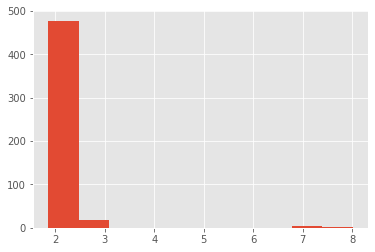

In [18]:
# лучше не стало
loga_test.hist()

In [19]:
st.normaltest(loga_test)

NormaltestResult(statistic=800.4026430070121, pvalue=1.5659374863543855e-174)

In [20]:
# p < 0.05 отвергаем нулевую гипотезу - разница есть??
st.ttest_ind(control.value, loga_test)

Ttest_indResult(statistic=154.9771697811308, pvalue=0.0)

#### Посчитайте p-value: U-тест Mann-Whitney (менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов). (2/3)

In [21]:
st.mannwhitneyu(control.value, test.value)
# p > 0.05 - оставляем нулевую гипотезу?

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

#### Посчитайте p-value: бутстрап. (3/3)

In [22]:
# посмотрим средние и медианы двух выборок
control.value.describe()

count    500.000000
mean      10.026867
std        0.979377
min        6.436541
25%        9.411024
50%       10.018465
75%       10.664879
max       13.130346
Name: value, dtype: float64

In [23]:
# средние групп отличаются на 17 единиц, а медианы приблизительно равны, при этом у контрольной группы среднее приблизительно равно медиане
test.value.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

In [24]:
# проведём бутстрап для средних

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = st.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

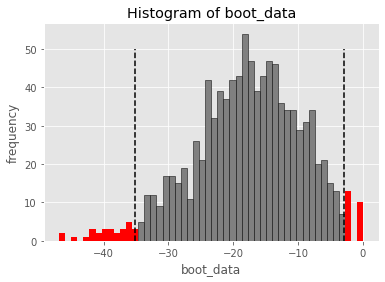

In [25]:
booted_data = get_bootstrap(control.value, test.value)

In [26]:
# p < 0.05
booted_data["p_value"]

0.03254869675922687

In [27]:
# 0 не попал в дов интервал - принимаем альтернативную гипотезу
booted_data["quants"]

,0
0.025,-35.167993
0.975,-2.968550


А что если избавиться от выбросов в тестовой группе?

In [28]:
# пять выбросов в тестовой группе
test[test.value >= 100]

,value,experimentVariant
995,1000.0,Treatment
996,1200.0,Treatment
997,1500.0,Treatment
998,2000.0,Treatment
999,3000.0,Treatment


In [29]:
# убираем выбросы в тестовой группе
test_no_outliers = test[test.value < 100]

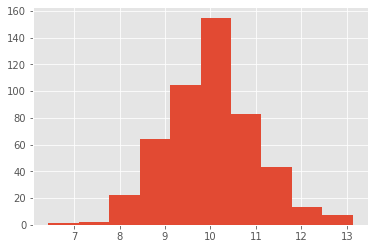

In [30]:
# распределение ближе к нормальному?
test_no_outliers.value.hist()

In [31]:
# проверка на нормальность распределения: тест Шапиро-Уилка (но на больших выборках может сработать некорректно)
st.shapiro(test_no_outliers.value)
# p > 0.05 - нет достаточных оснований утверждать, что данные распределены ненормально

ShapiroResult(statistic=0.9955515265464783, pvalue=0.17188233137130737)

In [32]:
# распределение групп на нормальность: scipy.stats.normaltest()
st.normaltest(test_no_outliers.value)
# p > 0.05 - нет достаточных оснований утверждать, что данные распределены ненормально

NormaltestResult(statistic=3.4264513588191425, pvalue=0.18028331749803517)

In [33]:
# требование гомогенности дисперсий: тест Левена
st.levene(control.value, test_no_outliers.value)
# p > 0.05 - похоже, дисперсии гомогенные

LeveneResult(statistic=0.004297981921358907, pvalue=0.9477421313655946)

In [34]:
# t-test
st.ttest_ind(control.value, test_no_outliers.value)
# p > 0.05 оставляем нулевую гипотезу??

Ttest_indResult(statistic=0.08299135107595523, pvalue=0.9338751428058142)

In [35]:
#  U-тест
st.mannwhitneyu(control.value, test_no_outliers.value)
# p > 0.05 - оставляем нулевую гипотезу

MannwhitneyuResult(statistic=124189.5, pvalue=0.9228386264147465)

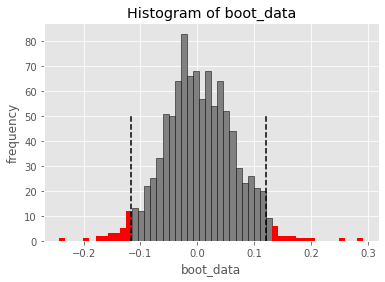

In [36]:
# бутстрап
booted_data2 = get_bootstrap(control.value, test_no_outliers.value)

In [37]:
# p > 0.05
booted_data2["p_value"]

0.960613805763801

In [38]:
# 0 входит в ДИ
booted_data2["quants"]

,0
0.025,-0.116943
0.975,0.120737


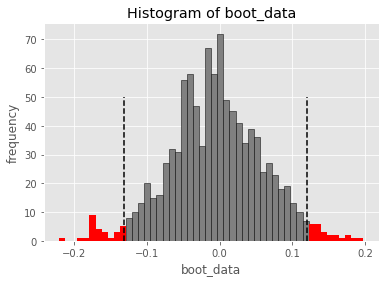

In [39]:
# дополнение: бутстрап по медиане на исходных данных
booted_data_median = get_bootstrap(control.value, test.value, statistic = np.median)

In [40]:
# p > 0.05
booted_data_median["p_value"]

0.9323497650152354

In [41]:
# 0 входит в ДИ
booted_data_median["quants"]

,0
0.025,-0.13081
0.975,0.11982


# Выводы

Нулевая гипотеза: Разницы между средним выручки в тестовой и контрольной группе нет.

Альтернативная гипотеза: разница есть.


## I. Заметки до проведения тестов:

1) Данные контрольной и тестовой группы содержат одинаковое количество наблюдений (500). Распределение у тестовой группы не является нормальным, присутствуют выбросы. Требование гомогенности дисперсий не соблюдено. Логарифмирование значений тестовой группы также не помогло приблизить распределение к нормальному.

2) **T-test кажется наименее подходящим** для анализа групп, так как не соблюдены его основные требования.

3) Отмечу, что средние значения групп отличаются на 17 единиц, а медианы приблизительно равны, при этом у контрольной группы среднее приблизительно равно медиане. Повлияли ли выбросы на значения средних?


## II. Проведём три теста на данных, результаты:

1) t-test: *p < 0.05 - отвергаем нулевую гипотезу*

2) U-тест: *p > 0.05 - оставляем нулевую гипотезу*

3) бутстрап: *p < 0.05, 0 не попал в ДИ - принимаем альтернативную гипотезу*


## III. Проведём три теста на данных *без выбросов*, результаты:

Если убрать 5 выбросов из тестовой группы, то ее распределение становится намного ближе к нормальному, а также соблюдается требование к гомогенности дисперсий между двумя группами.

1) t-test: *p > 0.05 - оставляем нулевую гипотезу*

2) U-тест: *p > 0.05 - оставляем нулевую гипотезу*

3) бутстрап: *p > 0.05, 0 попал в ДИ - оставляем нулевую гипотезу*


## IV. Итог:


Учитывая значительное влияние даже малого количество выбросов на среднее (1) и наличие 5 выбросов в тестовой группе (2), я бы выбрала один из подходов:

- убрать 5 выбросов из тестовой группы и проводить сравнение средних одним из трёх представленных тестов

- провести U-тест как наиболее адекватный при выбросах и отсутствии критерия нормальности распределения

- провести бутстрап медиан.


Мне кажется, здесь есть большой риск совершить ошибку первого рода и отвергнуть нулевую гипотезу. Я бы оставила нулевую гипотезу - разницы между средним выручки в тестовой и контрольной группе нет, т.е. **больше зарабатывать с пользователя не стали**.